29.10.2024

https://home.agh.edu.pl/~mdig/dokuwiki/doku.php?id=teaching:data_science:ml_en:topics:nn_intro

https://pytorch.org/audio/stable/tutorials/speech_recognition_pipeline_tutorial.html

# Task 3 - tutorial

In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.5.0+cu121
2.5.0+cu121
cpu


In [ ]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

100%|██████████| 106k/106k [00:00<00:00, 4.71MB/s]


In [ ]:
SPEECH_FILE

'/root/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav'

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:05<00:00, 65.6MB/s]


<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
IPython.display.Audio(SPEECH_FILE)

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

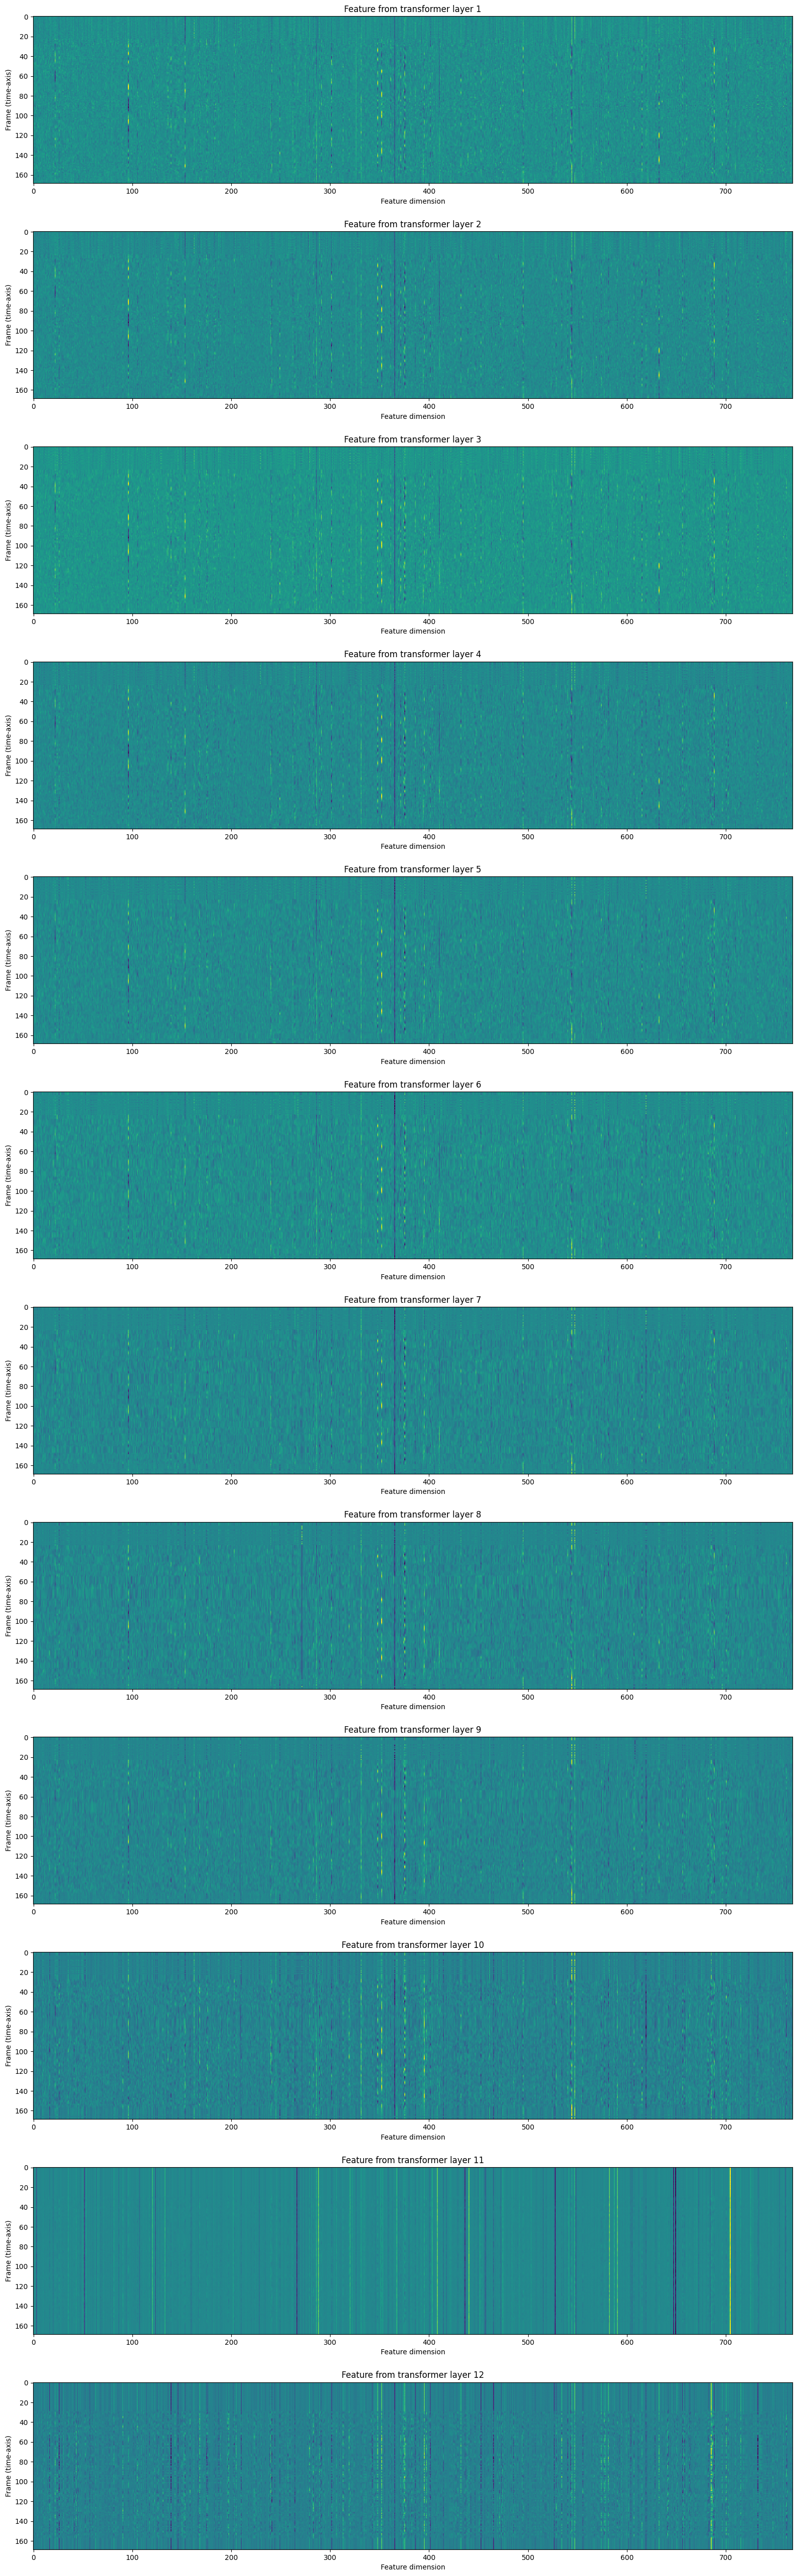

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [ ]:
emission.shape

torch.Size([1, 169, 29])

In [ ]:
len(bundle.get_labels())

29

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


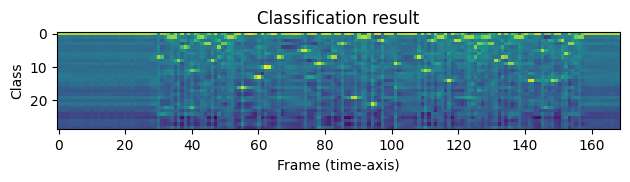

In [ ]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


# Task 3 - own implementation

In [ ]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

In [ ]:
print(torch.__version__)
print(torchaudio.__version__)

2.5.0+cu121
2.5.0+cu121


In [ ]:
ResampledWaveform = torch.Tensor
AudioFeatures = torch.Tensor
EmmisionsTensor = torch.Tensor


class TranscriptGenerator:

    def __init__(self):
        torch.random.manual_seed(0)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
        self.sample_rate = self.bundle.sample_rate
        self.labels = self.bundle.get_labels()
        self.model = self.bundle.get_model().to(self.device)

    def display_audio_file_ipy(self, path_to_file):
        IPython.display.Audio(path_to_file)

    def correct_sampling(self, path_to_file: str) -> ResampledWaveform:
        waveform, sample_rate = torchaudio.load(path_to_file)
        waveform = waveform.to(self.device)

        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)

        return waveform

    def extract_features(self, waveform: ResampledWaveform) -> AudioFeatures:
        with torch.inference_mode():
            features, _ = self.model.extract_features(waveform)
        return features

    def visualise_features(self, features: AudioFeatures) -> None:
        fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
        for i, feats in enumerate(features):
            ax[i].imshow(feats[0].cpu(), interpolation="nearest")
            ax[i].set_title(f"Feature from transformer layer {i+1}")
            ax[i].set_xlabel("Feature dimension")
            ax[i].set_ylabel("Frame (time-axis)")
        fig.tight_layout()

    def classification(self, waveform: ResampledWaveform) -> EmmisionsTensor:
        with torch.inference_mode():
            emmision, _ = self.model(waveform)

    def visualise_emmisions(self, emmisions: EmmisionsTensor) -> None:
        plt.imshow(emission[0].cpu().T, interpolation="nearest")
        plt.title("Classification result")
        plt.xlabel("Frame (time-axis)")
        plt.ylabel("Class")
        plt.tight_layout()
        print("Class labels:", self.labels)

    def pipeline(self, file_path):
        self.display_audio_file_ipy(file_path)
        corrected = self.correct_sampling(file_path)
        features = self.extract_features(corrected)
        self.visualise_features(features)
        emmisions = self.classification(corrected)
        self.visualise_emmisions(emmisions)

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


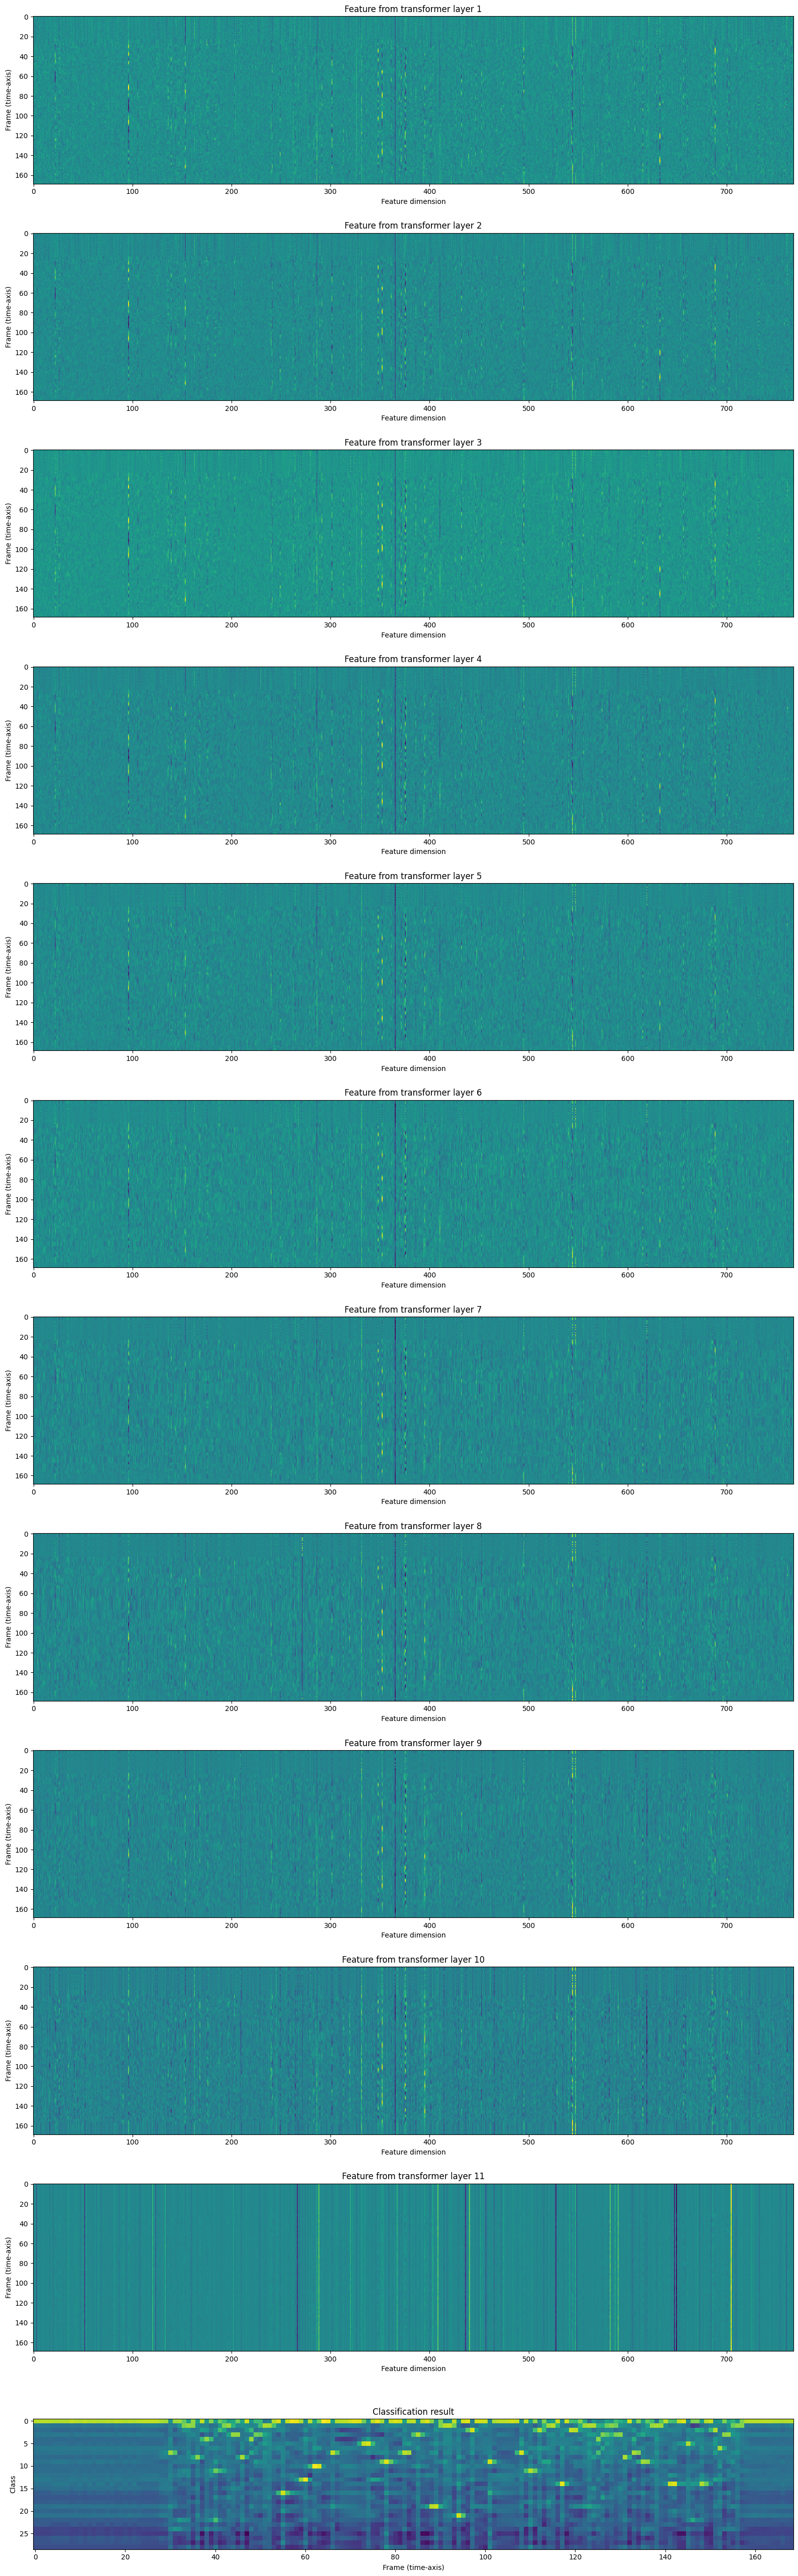

In [ ]:
tg = TranscriptGenerator()

tg.pipeline(SPEECH_FILE)